### Imports

In [1]:
import functools as ft
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import yaml

from bagpy import bagreader
from pathlib import Path
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

### Constants

In [2]:
BATCH_SIZE = 32
INPUT_SIZE = 8
NUM_EPOCHS = 10
DATA_DIR = Path('../data/dataset/')
LOOKBACK = 2.
SAMPLING_FREQUENCY = 100.
DATASET_FREQUENCY = 200.
SUBSET = ['imu', 'servo']

### Directories

In [2]:
# bag_dir = '../data/pb_rosbag/Linoleum/kwadrat/2023-01-16-17-42-29'
# bag_dir = '../data/pb_rosbag/Linoleum/kwadrat/Linoleum1'
bag_dir = '../data/pb_rosbag/Linoleum/osemka/2023-01-14-16-18-46'
# bag_dir = '../data/pb_rosbag/Mata/osemka/2023-01-15-16-45-26'
# bag_dir = '../data/pb_rosbag/Panele/osemka/2023-01-05-18-14-50'
# bag_dir = '../data/pb_rosbag/Plytki/osemka/2023-01-15-15-51-50'
# bag_dir = '../data/pb_rosbag/Podklady/osemka/2023-01-15-14-22-29'
# bag_dir = '../data/pb_rosbag/PustaPlyta/osemka/2023-01-15-13-28-26'
# bag_dir = '../data/pb_rosbag/QR/osemka/2023-01-14-15-08-02'
# bag_dir = '../data/pb_rosbag/Trawa/osemka/2023-01-14-12-51-39'
# bag_dir = '../data/pb_rosbag/wykCzarn/osemka/2023-01-10-16-48-06'
# bag_dir = '../data/pb_rosbag/wykJasna/osemka/2023-01-12-13-37-03'
# bag_dir = '../data/fixed/1_Panele/6W/R1/circlesT1/panels_1_2023-07-17-14-25-00'

# Sinlge run

### Load data from csv

In [3]:
bag_file_path = bag_dir + '.bag'
b = bagreader(bag_file_path)

[INFO]  Data folder ../data/pb_rosbag/Linoleum/osemka/2023-01-14-16-18-46 already exists. Not creating.


In [4]:
b.topic_table

Topics                            Types  Message Count  \
0                /Servo_data        kin_odom_msg/Measurements            630   
1                   /cmd_vel              geometry_msgs/Twist           1990   
2         /filter/quaternion  geometry_msgs/QuaternionStamped           3068   
3                    /ground                  std_msgs/String              2   
4          /imu/acceleration     geometry_msgs/Vector3Stamped           3062   
5      /imu/angular_velocity     geometry_msgs/Vector3Stamped           3062   
6                  /imu/data                  sensor_msgs/Imu           3068   
7                   /imu/mag     geometry_msgs/Vector3Stamped           3062   
8              /imu/time_ref        sensor_msgs/TimeReference           3062   
9                      /odom                nav_msgs/Odometry           1582   
10                   /rosout                rosgraph_msgs/Log             26   
11               /rosout_agg                rosgraph_msgs/Log             19   
12                       /tf               tf2_msgs/TFMessage           8150   
13    /turtlebot_burger/odom                nav_msgs/Odometry           3164   
14                 /velocity       kin_odom_msg/VelocityWheel            634   
15   /vicon/turtlebot_burger                    vicon/Subject           3169   
16  /vicon/unlabeled_markers                    vicon/Markers           3169   
17           /wheel_feedback       kin_odom_msg/VelocityWheel            630   

        Frequency  
0       20.770462  
1       68.413649  
2      299.059109  
3        0.802389  
4      305.818739  
5      305.997228  
6      296.438194  
7      302.619336  
8      303.539152  
9       54.264290  
10   21076.904523  
11  133152.507937  
12     339.180333  
13   35544.949153  
14      20.011374  
15      99.954816  
16      99.814474  
17      20.735857

In [5]:
topic_data = {file[:-4]: pd.read_csv(os.path.join(bag_dir, file)) for file in os.listdir(bag_dir)}

### Topics visualization

In [6]:
cmd_vel = topic_data['cmd_vel']
cmd_vel

Time  linear.x  linear.y  linear.z  angular.x  angular.y  \
0     1.673710e+09      0.00       0.0       0.0        0.0        0.0   
1     1.673710e+09      0.00       0.0       0.0        0.0        0.0   
2     1.673710e+09      0.09       0.0       0.0        0.0        0.0   
3     1.673710e+09      0.09       0.0       0.0        0.0        0.0   
4     1.673710e+09      0.09       0.0       0.0        0.0        0.0   
...            ...       ...       ...       ...        ...        ...   
1985  1.673710e+09      0.09       0.0       0.0        0.0        0.0   
1986  1.673710e+09      0.09       0.0       0.0        0.0        0.0   
1987  1.673710e+09      0.09       0.0       0.0        0.0        0.0   
1988  1.673710e+09      0.09       0.0       0.0        0.0        0.0   
1989  1.673710e+09      0.00       0.0       0.0        0.0        0.0   

      angular.z  
0      0.000000  
1      0.000000  
2      0.600161  
3      0.580990  
4      0.566352  
...         ...  
1985  -0.450334  
1986  -0.493904  
1987  -0.473333  
1988  -0.442051  
1989   0.000000  

[1990 rows x 7 columns]

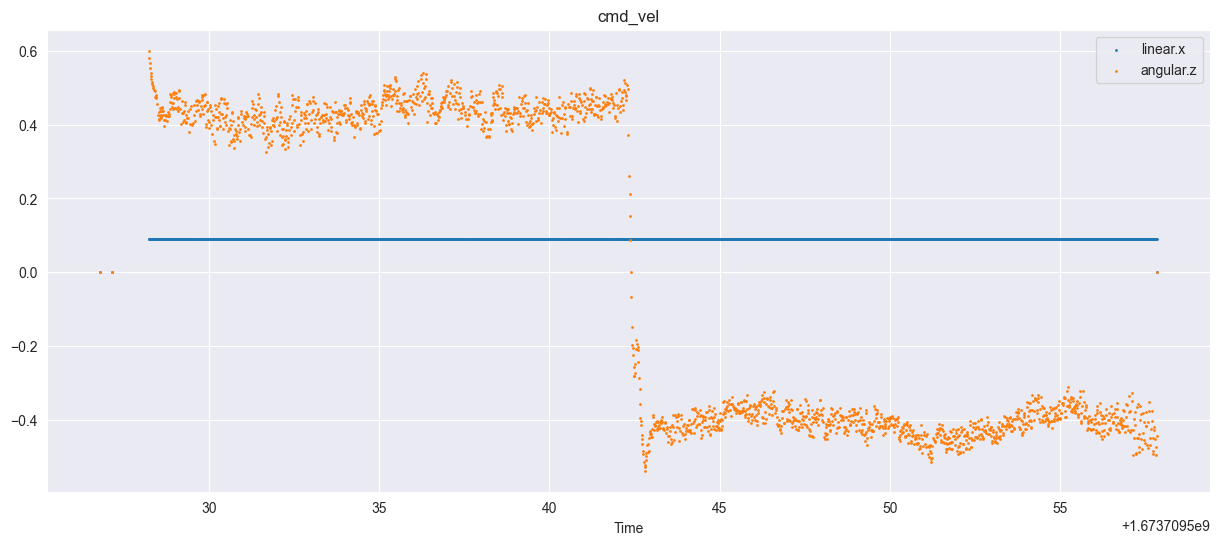

In [8]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['linear.x', 'angular.z']
for col in cols:
    plt.scatter(x=cmd_vel['Time'], y=cmd_vel[col], s=1, label=col)
plt.title('cmd_vel')
plt.xlabel('Time')
plt.legend()
plt.show()

In [9]:
# plt.rcParams['figure.figsize'] = [15, 6]
# cols = ['twist.linear.x', 'twist.angular.z']
# for col in cols:
#     plt.scatter(x=cmd_vel['Time'], y=cmd_vel[col], s=1, label=col)
# plt.title('cmd_vel')
# plt.xlabel('Time')
# plt.legend()
# plt.show()

In [10]:
imu_acceleration = topic_data['imu-acceleration']
imu_acceleration

Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0     1.673710e+09     1458031         1673709526            57986776   
1     1.673710e+09     1458032         1673709526            58001819   
2     1.673710e+09     1458033         1673709526            58010056   
3     1.673710e+09     1458034         1673709526            58017927   
4     1.673710e+09     1458035         1673709526            58025452   
...            ...         ...                ...                 ...   
3057  1.673710e+09     1461088         1673709557           506076480   
3058  1.673710e+09     1461089         1673709557           506092374   
3059  1.673710e+09     1461090         1673709557           506100599   
3060  1.673710e+09     1461091         1673709557           506108585   
3061  1.673710e+09     1461092         1673709557           506116219   

     header.frame_id  vector.x  vector.y   vector.z  
0           imu_link -0.080281  0.144533  10.033216  
1           imu_link -0.083087  0.146638  10.012651  
2           imu_link -0.082985  0.150829  10.019607  
3           imu_link -0.107023  0.142482  10.010639  
4           imu_link -0.091056  0.142806  10.022118  
...              ...       ...       ...        ...  
3057        imu_link -0.390987  0.058410  10.013300  
3058        imu_link -0.376841  0.088510   9.779983  
3059        imu_link -0.212219  0.189846   9.934262  
3060        imu_link -0.167956  0.373394  10.049113  
3061        imu_link -0.240568  0.458069  10.035980  

[3062 rows x 8 columns]

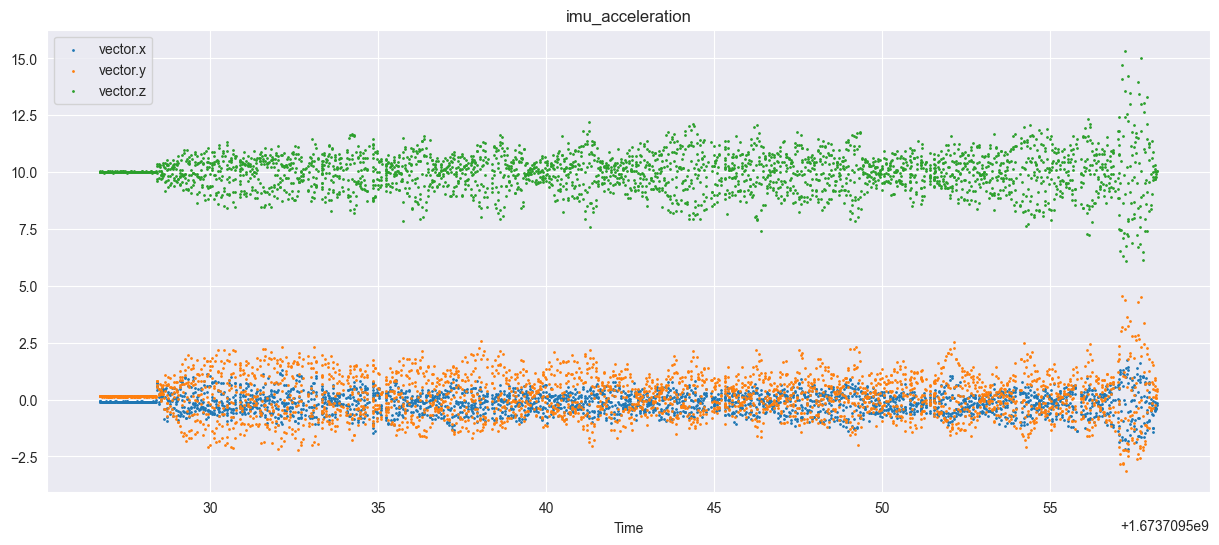

In [11]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['vector.x', 'vector.y', 'vector.z']
for col in cols:
    plt.scatter(x=imu_acceleration['Time'], y=imu_acceleration[col], s=1, label=col)
plt.title('imu_acceleration')
plt.xlabel('Time')
plt.legend()
plt.show()

In [12]:
imu_angular_velocity = topic_data['imu-angular_velocity']
imu_angular_velocity

Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0     1.673710e+09     1458031         1673709526            57986776   
1     1.673710e+09     1458032         1673709526            58001819   
2     1.673710e+09     1458033         1673709526            58010056   
3     1.673710e+09     1458034         1673709526            58017927   
4     1.673710e+09     1458035         1673709526            58025452   
...            ...         ...                ...                 ...   
3057  1.673710e+09     1461088         1673709557           506076480   
3058  1.673710e+09     1461089         1673709557           506092374   
3059  1.673710e+09     1461090         1673709557           506100599   
3060  1.673710e+09     1461091         1673709557           506108585   
3061  1.673710e+09     1461092         1673709557           506116219   

     header.frame_id  vector.x  vector.y  vector.z  
0           imu_link  0.011907 -0.000857 -0.013538  
1           imu_link  0.012663 -0.001181 -0.014108  
2           imu_link  0.012237 -0.000575 -0.013113  
3           imu_link  0.011892 -0.001629 -0.012078  
4           imu_link  0.011166 -0.000311 -0.012219  
...              ...       ...       ...       ...  
3057        imu_link -0.009360 -0.024467 -0.088560  
3058        imu_link  0.025074 -0.013294 -0.078857  
3059        imu_link  0.034097  0.004222 -0.060325  
3060        imu_link  0.024255 -0.001986 -0.038178  
3061        imu_link  0.009848 -0.001181 -0.021389  

[3062 rows x 8 columns]

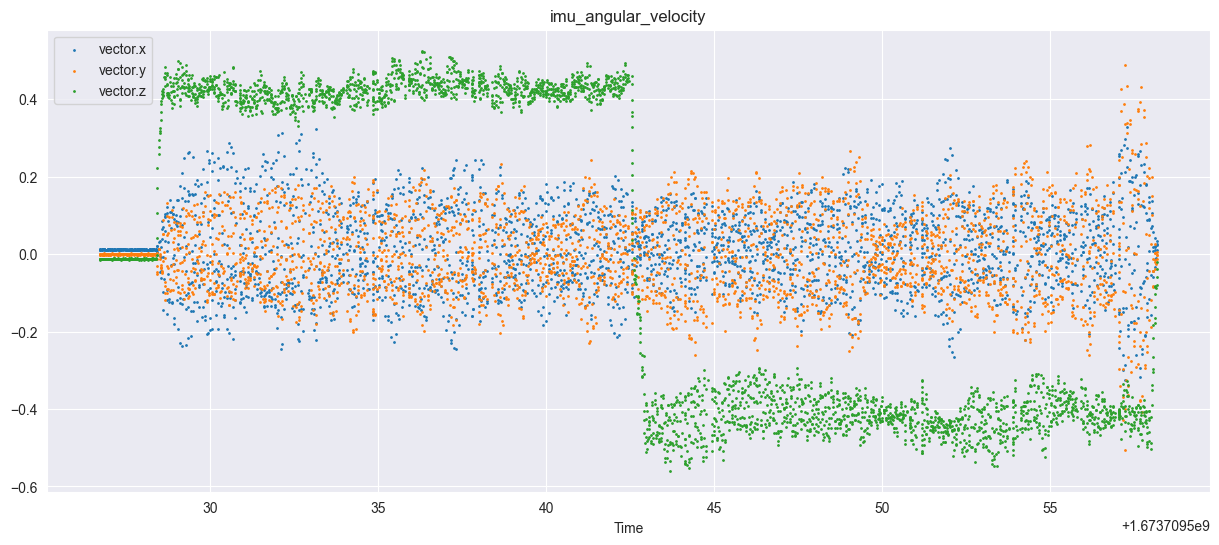

In [13]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['vector.x', 'vector.y', 'vector.z']
for col in cols:
    plt.scatter(x=imu_angular_velocity['Time'], y=imu_angular_velocity[col], s=1, label=col)
plt.title('imu_angular_velocity')
plt.xlabel('Time')
plt.legend()
plt.show()

In [14]:
odom = topic_data['odom']
odom

Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0     1.673710e+09      743197         1673709525           895565312   
1     1.673710e+09      743198         1673709525           915634307   
2     1.673710e+09      743199         1673709525           935601994   
3     1.673710e+09      743200         1673709525           955565372   
4     1.673710e+09      743201         1673709525           975680167   
...            ...         ...                ...                 ...   
1577  1.673710e+09      744774         1673709557           435602244   
1578  1.673710e+09      744775         1673709557           455608245   
1579  1.673710e+09      744776         1673709557           475686738   
1580  1.673710e+09      744777         1673709557           495610050   
1581  1.673710e+09      744778         1673709557           515622531   

     header.frame_id child_frame_id  pose.pose.position.x  \
0               odom      base_link              0.077483   
1               odom      base_link              0.077483   
2               odom      base_link              0.077483   
3               odom      base_link              0.077483   
4               odom      base_link              0.077483   
...              ...            ...                   ...   
1577            odom      base_link              0.050444   
1578            odom      base_link              0.050919   
1579            odom      base_link              0.051395   
1580            odom      base_link              0.051587   
1581            odom      base_link              0.051779   

      pose.pose.position.y  pose.pose.position.z  pose.pose.orientation.x  \
0                -0.016683                   0.0                      0.0   
1                -0.016683                   0.0                      0.0   
2                -0.016683                   0.0                      0.0   
3                -0.016683                   0.0                      0.0   
4                -0.016683                   0.0                      0.0   
...                    ...                   ...                      ...   
1577             -0.002965                   0.0                      0.0   
1578             -0.003028                   0.0                      0.0   
1579             -0.003092                   0.0                      0.0   
1580             -0.003118                   0.0                      0.0   
1581             -0.003145                   0.0                      0.0   

      ...  pose.pose.orientation.z  pose.pose.orientation.w  \
0     ...                -0.000644                 1.000000   
1     ...                -0.000644                 1.000000   
2     ...                -0.000644                 1.000000   
3     ...                -0.000644                 1.000000   
4     ...                -0.000644                 1.000000   
...   ...                      ...                      ...   
1577  ...                -0.065723                 0.997838   
1578  ...                -0.066870                 0.997762   
1579  ...                -0.068021                 0.997684   
1580  ...                -0.068574                 0.997646   
1581  ...                -0.069129                 0.997608   

                                        pose.covariance twist.twist.linear.x  \
0     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.000000   
1     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.000000   
2     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.000000   
3     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.000000   
4     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.000000   
...                                                 ...                  ...   
1577  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.023939   
1578  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.023939   
15

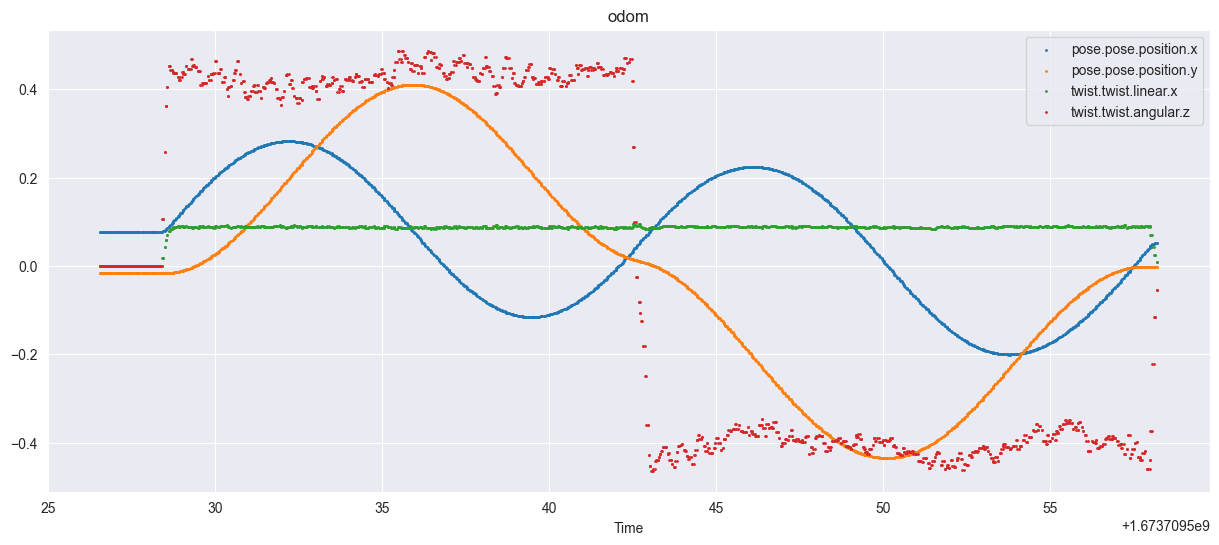

In [15]:
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z']
for col in cols:
    plt.scatter(x=odom['Time'], y=odom[col], s=1, label=col)
plt.title('odom')
plt.xlabel('Time')
plt.legend()
plt.show()

In [16]:
servo_data = topic_data['Servo_data']
servo_data

Time                                             values
0    1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: -7...
1    1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: -7...
2    1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: -7...
3    1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: -7...
4    1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: -7...
..            ...                                                ...
625  1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: 8....
626  1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: 4....
627  1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: 2....
628  1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: 1....
629  1.673710e+09  [ID: 1\nVoltage: 10.899999618530273\nAmper: 1....

[630 rows x 2 columns]

In [17]:
data = servo_data['values'].tolist()
data = [line.replace(', ', '];[') for line in data]
data = [line.replace('[', '') for line in data]
data = [line.replace(']', '') for line in data]
data = [line.split(sep=';') for line in data]
data = [[yaml.safe_load(line) for line in separate_lines] for separate_lines in data]
time = servo_data['Time']
columns = ['Power_' + str(idx + 1) for idx in range(len(data[0]))]
columns_left = ['Power_' + str(idx + 1) for idx in range(len(data[0])) if idx % 2 == 0]
columns_right = ['Power_' + str(idx + 1) for idx in range(len(data[0])) if idx % 2 != 0]
power = pd.DataFrame([[abs(tuple(dictionary.values())[1] * tuple(dictionary.values())[2]) / 1e3 for dictionary in line] for line in data], columns=columns)
power_left = pd.DataFrame([[abs(tuple(dictionary.values())[1] * tuple(dictionary.values())[2]) / 1e3 for idx, dictionary in enumerate(line) if idx % 2 == 0] for line in data], columns=columns_left)
power_right = pd.DataFrame([[abs(tuple(dictionary.values())[1] * tuple(dictionary.values())[2]) / 1e3 for idx, dictionary in enumerate(line) if idx % 2 != 0] for line in data], columns=columns_right)
mean_power = pd.concat([time, power.mean(axis=1)], axis=1)
mean_power.columns = ['Time', 'mean_power']
mean_power_left = pd.concat([time, power_left.mean(axis=1)], axis=1)
mean_power_left.columns = ['Time', 'mean_power_left']
mean_power_right = pd.concat([time, power_right.mean(axis=1)], axis=1)
mean_power_right.columns = ['Time', 'mean_power_right']
power = pd.concat([time, power], axis=1)

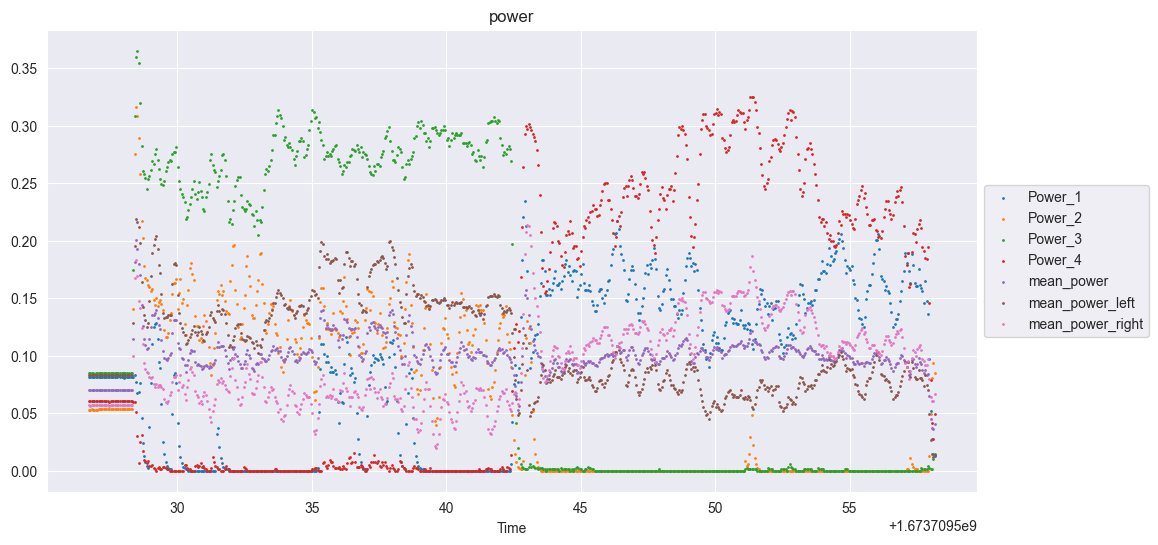

In [18]:
_, ax = plt.subplots(figsize=(15, 6))
for column in power.columns[1:]:
    ax.scatter(x=power['Time'], y=power[column], s=1, label=column)
ax.scatter(x=mean_power['Time'], y=mean_power['mean_power'], s=1, label='mean_power')
ax.scatter(x=mean_power_left['Time'], y=mean_power_left['mean_power_left'], s=1, label='mean_power_left')
ax.scatter(x=mean_power_right['Time'], y=mean_power_right['mean_power_right'], s=1, label='mean_power_right')
ax.set_title('power')
ax.set_xlabel('Time')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Refine data

In [19]:
imu_data = topic_data['imu-data']

In [20]:
cmd_vel_refined = cmd_vel.drop(columns=['linear.y', 'linear.z', 'angular.x', 'angular.y'])
imu_acceleration_refined = imu_data[['Time', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']]
imu_angular_velocity_refined = imu_data[['Time', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']]
odom_refined = odom.drop(columns=['header.seq', 'header.stamp.secs', 'header.stamp.nsecs', 'header.frame_id', 'child_frame_id',
                                  'pose.covariance', 'twist.covariance',
                                  'pose.pose.position.z',
                                  'pose.pose.orientation.x', 'pose.pose.orientation.y', 'pose.pose.orientation.z', 'pose.pose.orientation.w',
                                  'twist.twist.linear.y', 'twist.twist.linear.z', 'twist.twist.angular.x', 'twist.twist.angular.y'])

In [21]:
# cmd_vel_refined = cmd_vel.drop(columns=['header.seq', 'header.stamp.secs', 'header.stamp.nsecs', 'header.frame_id', 'twist.linear.y', 'twist.linear.z', 'twist.angular.x', 'twist.angular.y'])
# imu_acceleration_refined = imu_data[['Time', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']]
# imu_angular_velocity_refined = imu_data[['Time', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']]
# odom_refined = odom.drop(columns=['header.seq', 'header.stamp.secs', 'header.stamp.nsecs', 'header.frame_id', 'child_frame_id',
#                                   'pose.covariance', 'twist.covariance',
#                                   'pose.pose.position.z',
#                                   'pose.pose.orientation.x', 'pose.pose.orientation.y', 'pose.pose.orientation.z', 'pose.pose.orientation.w',
#                                   'twist.twist.linear.y', 'twist.twist.linear.z', 'twist.twist.angular.x', 'twist.twist.angular.y'])

In [22]:
dataframes = [cmd_vel_refined, imu_acceleration_refined, imu_angular_velocity_refined, odom_refined, mean_power, mean_power_left, mean_power_right]
dataframe = ft.reduce(lambda left, right: pd.merge(left, right, how='outer', on='Time'), dataframes)
dataframe.ffill(inplace=True)
dataframe.bfill(inplace=True)
dataframe['Time'] -= dataframe['Time'].min()
dataframe.set_index('Time', inplace=True)
dataframe

linear.x  angular.z  linear_acceleration.x  linear_acceleration.y  \
Time                                                                           
0.000000        0.0        0.0              -0.089096               0.135197   
0.009085        0.0        0.0              -0.089096               0.135197   
0.029316        0.0        0.0              -0.089096               0.135197   
0.048321        0.0        0.0              -0.089096               0.135197   
0.068473        0.0        0.0              -0.089096               0.135197   
...             ...        ...                    ...                    ...   
31.609905       0.0        0.0              -0.212219               0.189846   
31.613252       0.0        0.0              -0.167956               0.373394   
31.617194       0.0        0.0              -0.240568               0.458069   
31.623671       0.0        0.0              -0.240568               0.458069   
31.623832       0.0        0.0              -0.240568               0.458069   

           linear_acceleration.z  angular_velocity.x  angular_velocity.y  \
Time                                                                       
0.000000               10.014894            0.011374            0.001012   
0.009085               10.014894            0.011374            0.001012   
0.029316               10.014894            0.011374            0.001012   
0.048321               10.014894            0.011374            0.001012   
0.068473               10.014894            0.011374            0.001012   
...                          ...                 ...                 ...   
31.609905               9.934262            0.034097            0.004222   
31.613252              10.049113            0.024255           -0.001986   
31.617194              10.035980            0.009848           -0.001181   
31.623671              10.035980            0.009848           -0.001181   
31.623832              10.035980            0.009848           -0.001181   

           angular_velocity.z  pose.pose.position.x  pose.pose.position.y  \
Time                                                                        
0.000000            -0.012738              0.077483             -0.016683   
0.009085            -0.012738              0.077483             -0.016683   
0.029316            -0.012738              0.077483             -0.016683   
0.048321            -0.012738              0.077483             -0.016683   
0.068473            -0.012738              0.077483             -0.016683   
...                       ...                   ...                   ...   
31.609905           -0.060325              0.051395             -0.003092   
31.613252           -0.038178              0.051395             -0.003092   
31.617194           -0.021389              0.051395             -0.003092   
31.623671           -0.021389              0.051587             -0.003118   
31.623832           -0.021389              0.051779             -0.003145   

           twist.twist.linear.x  twist.twist.angular.z  mean_power  \
Time                                                                 
0.000000               0.000000               0.000000    0.070072   
0.009085               0.000000               0.000000    0.070072   
0.029316               0.000000               0.000000    0.070072   
0.048321               0.000000               0.000000    0.070072   
0.068473               0.000000               0.000000    0.070072   
...                         ...                    ...         ...   
31.609905              0.023939              -0.114938    0.040282   
31.613252              0.023939              -0.114938    0.040282   
31.617194              0.023939              -0.114938    0.040282   
31.623671              0.009694              -0.055615    0.040282   
31.623832              0.009694              -0.055615    0.040282   

           mean_power_left  mean_power_right  
Time                 

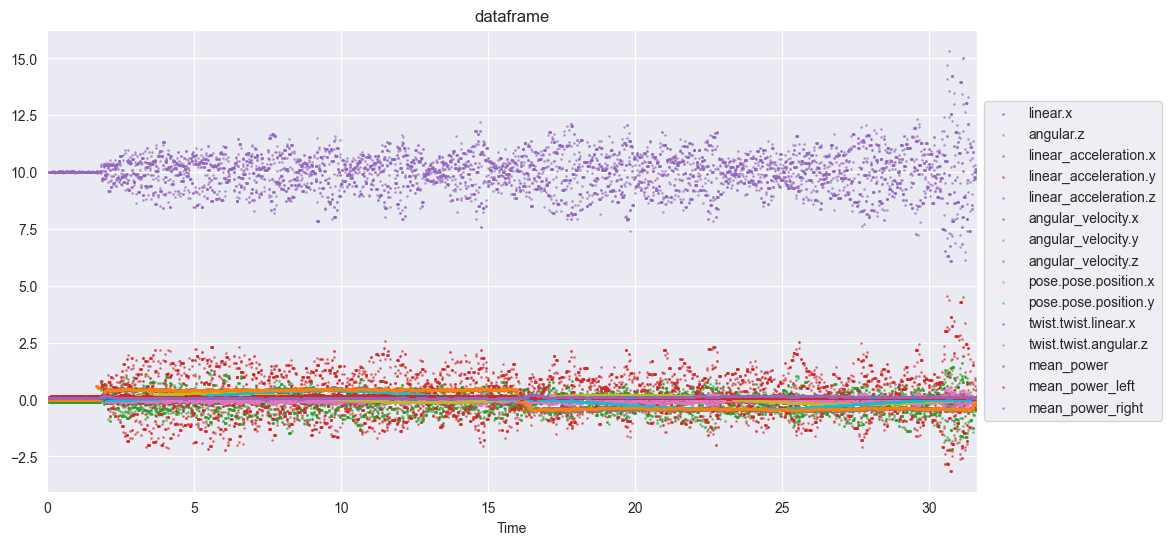

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

for column in dataframe.columns:
    ax.scatter(x=dataframe.index, y=dataframe[column], s=1, alpha=0.5, label=column)
ax.set_title('dataframe')
ax.set_xlabel('Time')
ax.set_xlim(dataframe.index[0], dataframe.index[-1])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Correlation matrix

(15.5, -0.5)

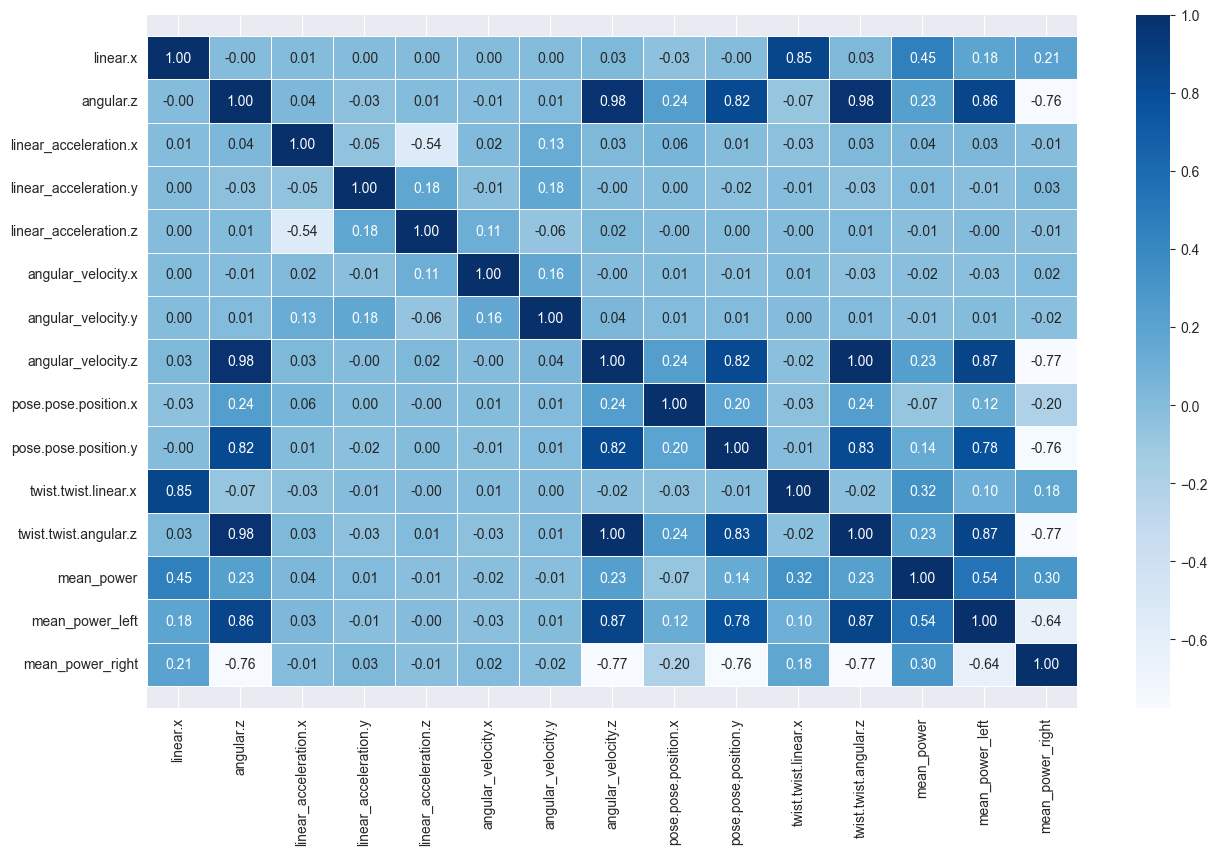

In [24]:
corr_matrix = dataframe.corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Correlation visualizations

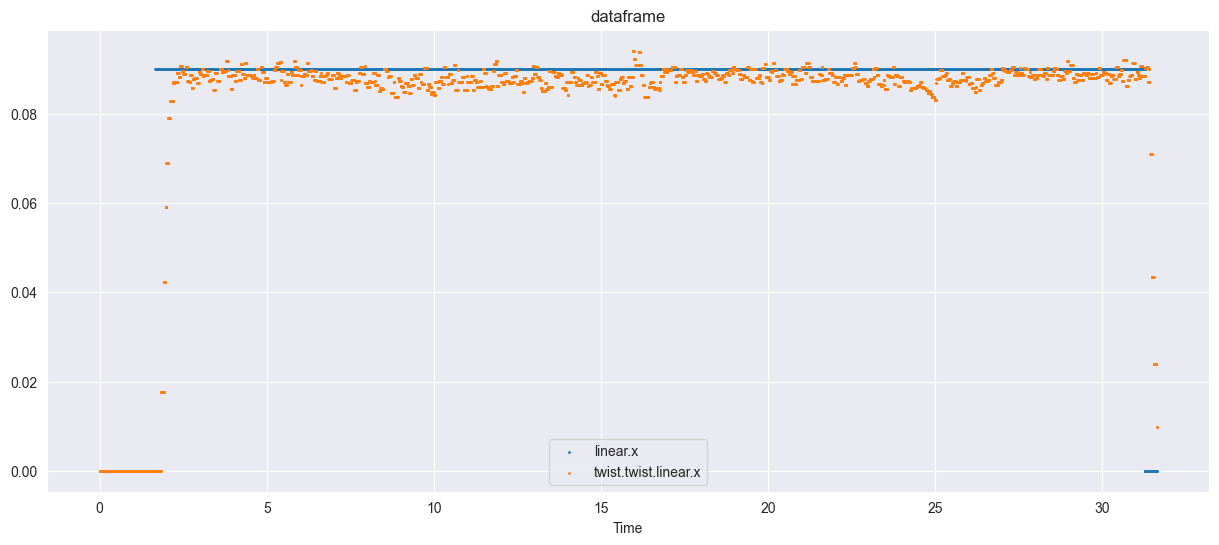

In [25]:
# cmd_vel / odom
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['linear.x', 'twist.twist.linear.x']
for col in cols:
    plt.scatter(x=dataframe.index, y=dataframe[col], s=1, label=col)
plt.title('dataframe')
plt.xlabel('Time')
plt.legend()
plt.show()

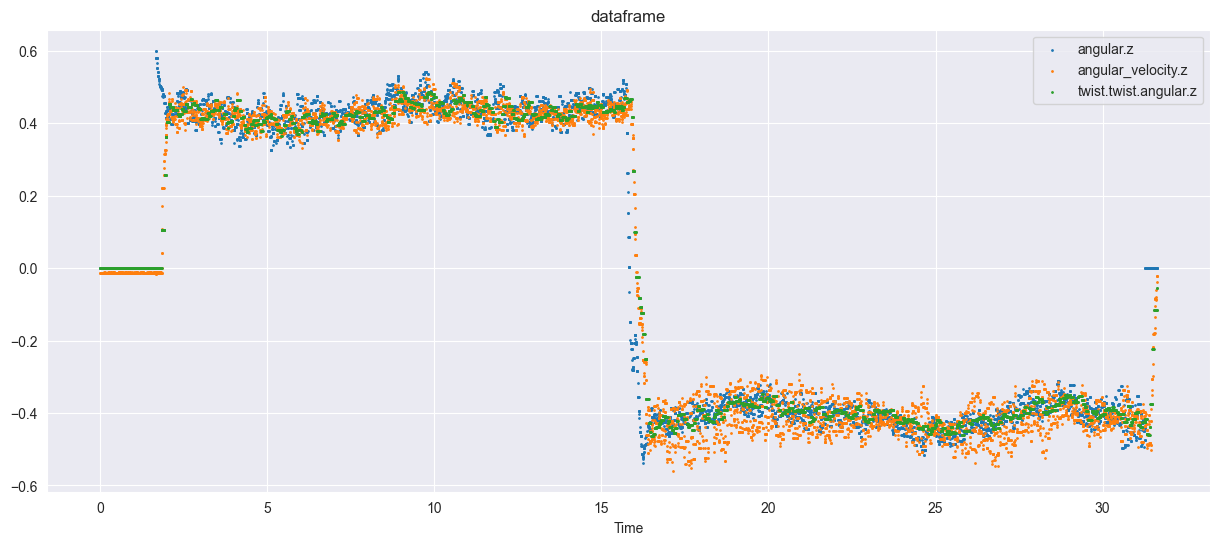

In [26]:
# cmd_vel / imu_angular_velocity / odom
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['angular.z', 'angular_velocity.z', 'twist.twist.angular.z']
for col in cols:
    plt.scatter(x=dataframe.index, y=dataframe[col], s=1, label=col)
plt.title('dataframe')
plt.xlabel('Time')
plt.legend()
plt.show()

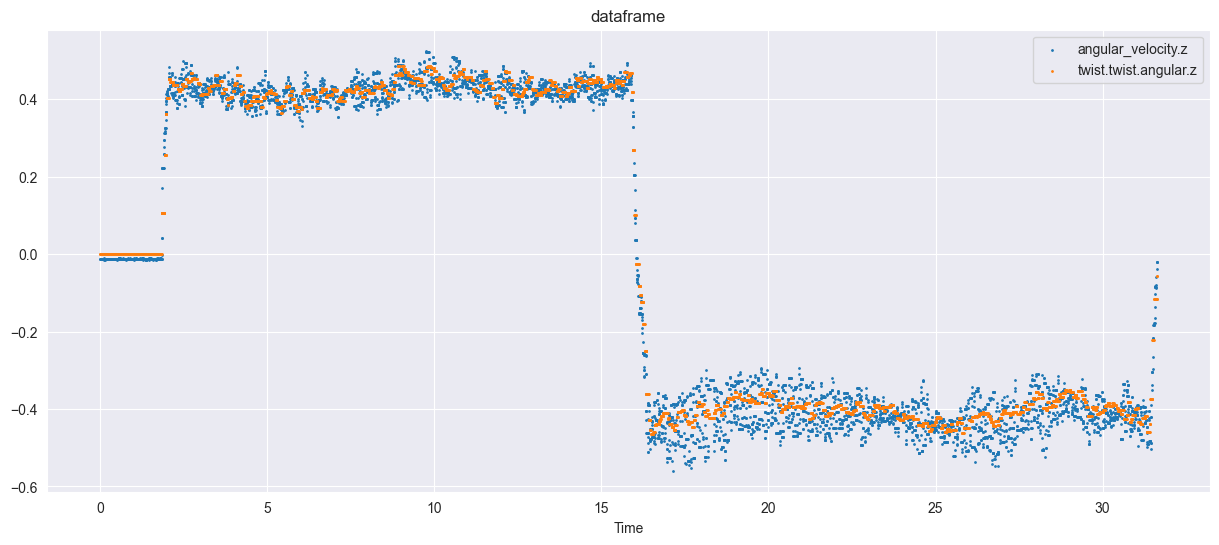

In [27]:
# imu_angular_velocity / odom
plt.rcParams['figure.figsize'] = [15, 6]
cols = ['angular_velocity.z', 'twist.twist.angular.z']
for col in cols:
    plt.scatter(x=dataframe.index, y=dataframe[col], s=1, label=col)
plt.title('dataframe')
plt.xlabel('Time')
plt.legend()
plt.show()

# All runs

In [3]:
with open('../data/labels.json') as fp:
    labels = json.load(fp)

In [4]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('6W',) and values['spacing'] == 'R1' and 'T1' in values['trajectory']]

In [5]:
files = pd.Series([run[0] for run in dataset], name='bag_name')
y = [run[1] for run in dataset]

In [6]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [8]:
X = [pd.read_csv(sample, index_col=[0])[[
    'linear_acceleration.x',
    'linear_acceleration.y',
    'linear_acceleration.z',
    'angular_velocity.x',
    'angular_velocity.y',
    'angular_velocity.z',
    'mean_power_left',
    'mean_power_right',
]] for sample in files]

for df, label in zip(X, y):
    df['target'] = label

X = pd.concat(X, axis=0)

In [9]:
X

linear_acceleration.x  linear_acceleration.y  linear_acceleration.z  \
0                  0.094402               0.055785               0.759342   
1                  0.360871               1.035011               0.356301   
2                  0.360871               1.035011               0.356301   
3                  0.360871               1.035011               0.356301   
4                  0.360871               1.035011               0.356301   
...                     ...                    ...                    ...   
5553              -0.014924              -0.417187               0.156030   
5554               0.440057              -0.124835              -0.392858   
5555               0.157724               0.723722              -0.120657   
5556               0.157724               0.723722              -0.120657   
5557               0.157724               0.723722              -0.120657   

      angular_velocity.x  angular_velocity.y  angular_velocity.z  \
0               0.014362            0.062669            0.394460   
1               0.035315           -0.002926            0.403166   
2               0.035315           -0.002926            0.403166   
3               0.035315           -0.002926            0.403166   
4               0.035315           -0.002926            0.403166   
...                  ...                 ...                 ...   
5553            0.011533           -0.054927           -0.457032   
5554            0.017747           -0.019197           -0.443420   
5555            0.030866            0.017809           -0.404981   
5556            0.030866            0.017809           -0.404981   
5557            0.030866            0.017809           -0.404981   

      mean_power_left  mean_power_right  target  
0             0.00118          0.035793       0  
1             0.00118          0.035793       0  
2             0.00118          0.035793       0  
3             0.00118          0.035793       0  
4             0.00118          0.035793       0  
...               ...               ...     ...  
5553          0.08103          0.004070       9  
5554          0.08103          0.004070       9  
5555          0.08103          0.004070       9  
5556          0.08103          0.004070       9  
5557          0.08103          0.003700       9  

[1646344 rows x 9 columns]

In [16]:
pd.DataFrame(mutual_info_classif(X.drop(['target'], axis=1), X['target']).reshape(1, -1), columns=X.drop(['target'], axis=1).columns, index=['Mutual Information'])

linear_acceleration.x  linear_acceleration.y  \
Mutual Information               1.304725                1.23351   

                    linear_acceleration.z  angular_velocity.x  \
Mutual Information               1.237549            1.156108   

                    angular_velocity.y  angular_velocity.z  mean_power_left  \
Mutual Information            1.237302            1.225342         1.718057   

                    mean_power_right  
Mutual Information          1.757312

(9.5, -0.5)

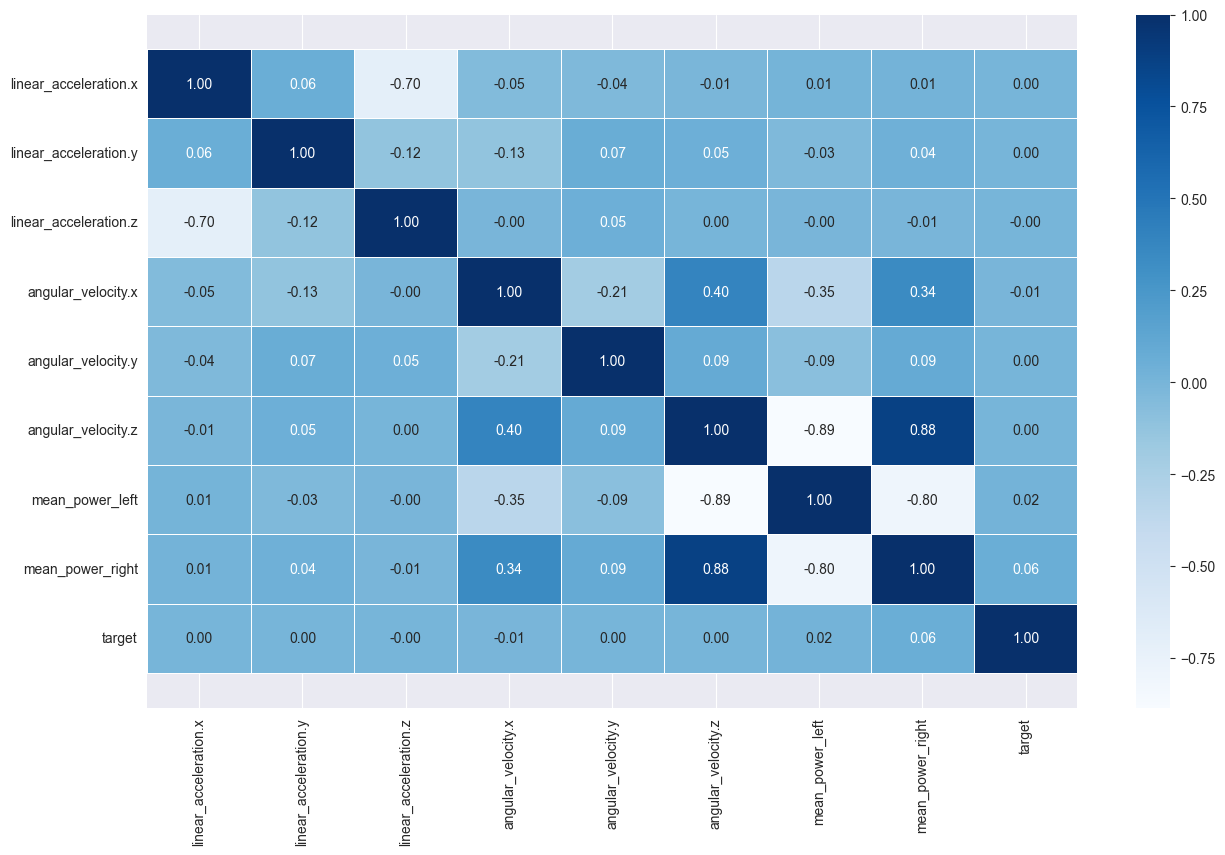

In [66]:
corr_matrix = X.corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

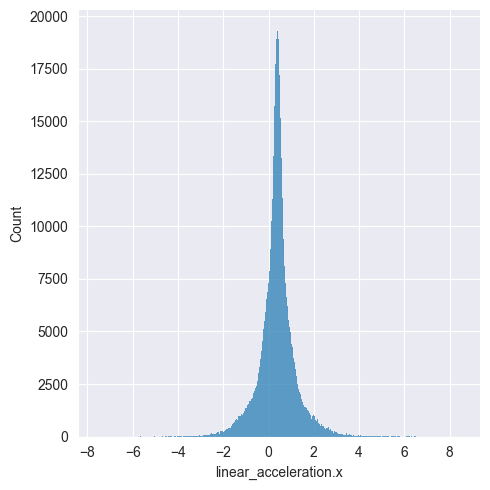

In [67]:
sns.displot(X, x='linear_acceleration.x')

MemoryError: Unable to allocate 3.80 GiB for an array with shape (509884286,) and data type int64

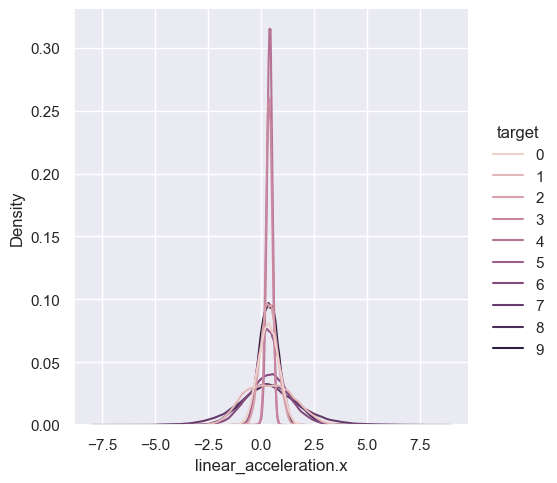

In [17]:
sns.displot(X, x='linear_acceleration.x', hue='target', kind='kde', fill=True)

D:\GitHub Projects\Surface classification\surface-classification\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\GitHub Projects\Surface classification\surface-classification\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


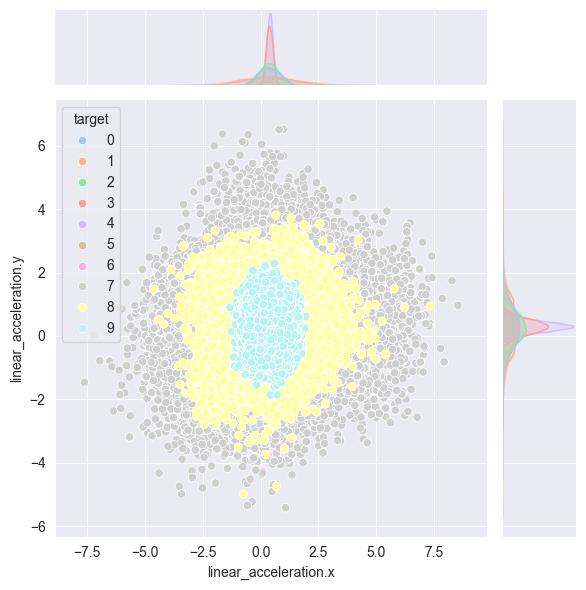

In [15]:
sns.jointplot(
    data=X,
    x="linear_acceleration.x", y="linear_acceleration.y", hue="target",
    # kind="kde"
)

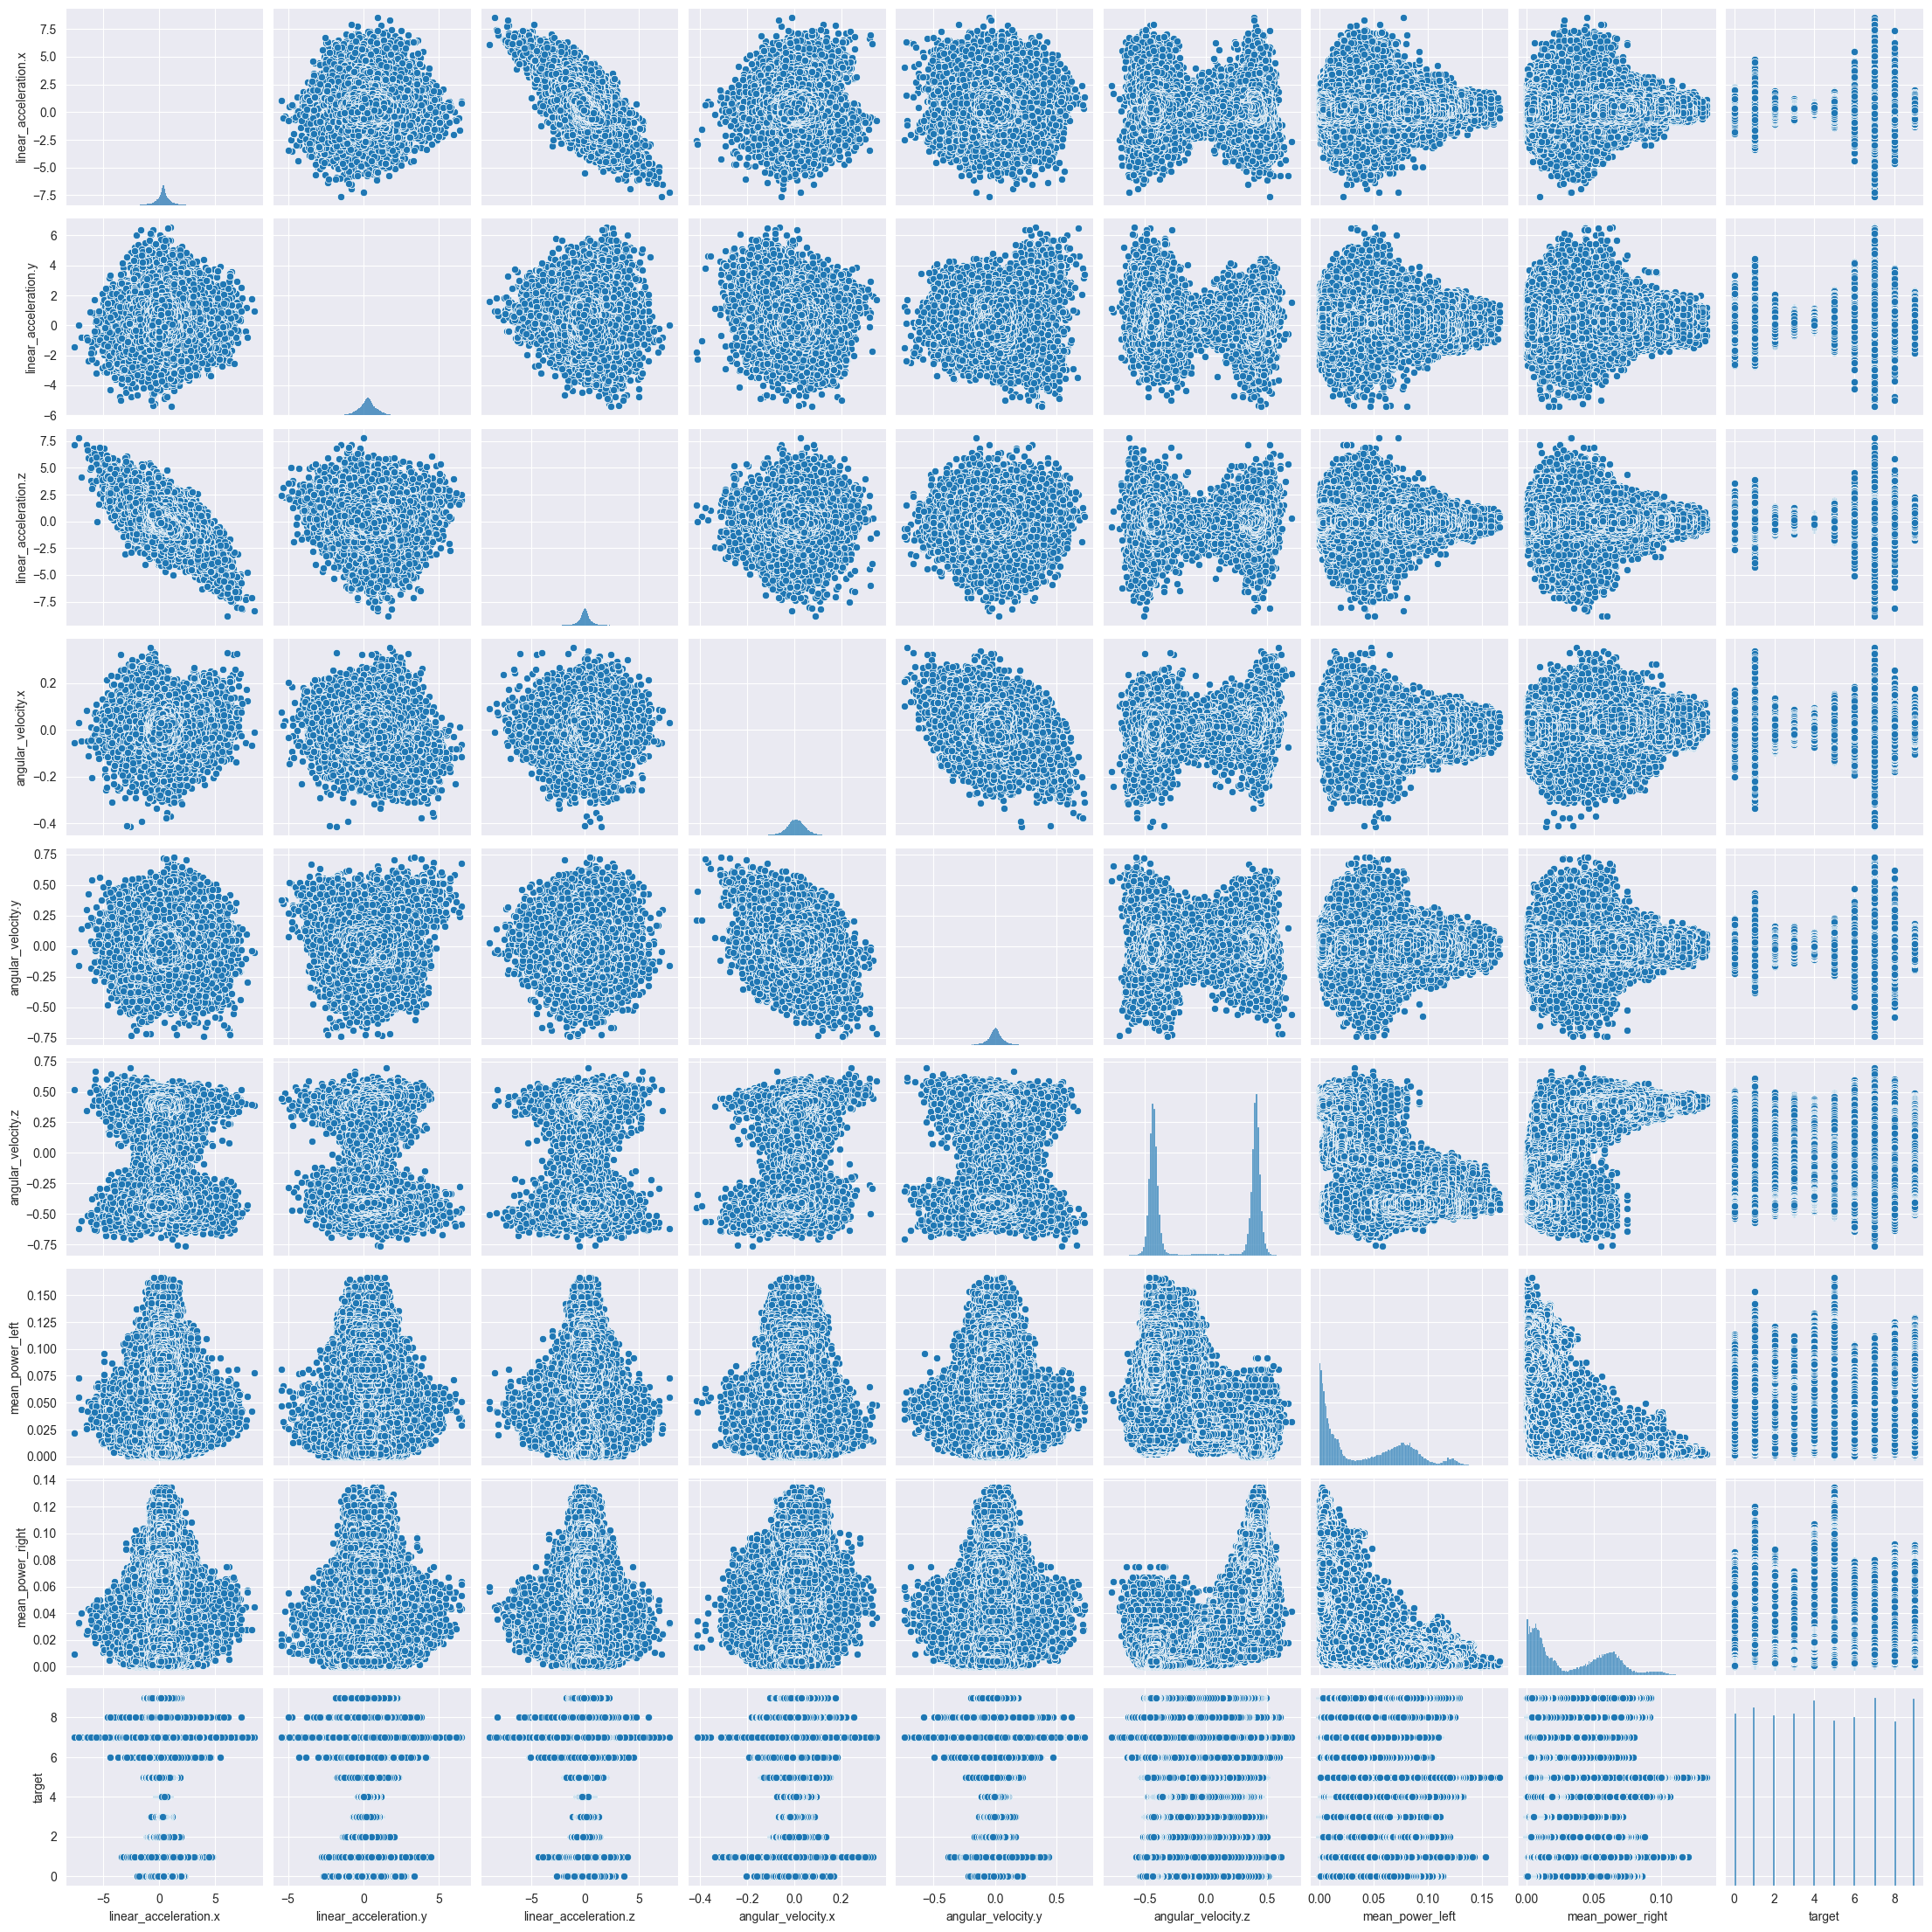

In [16]:
sns.pairplot(X)

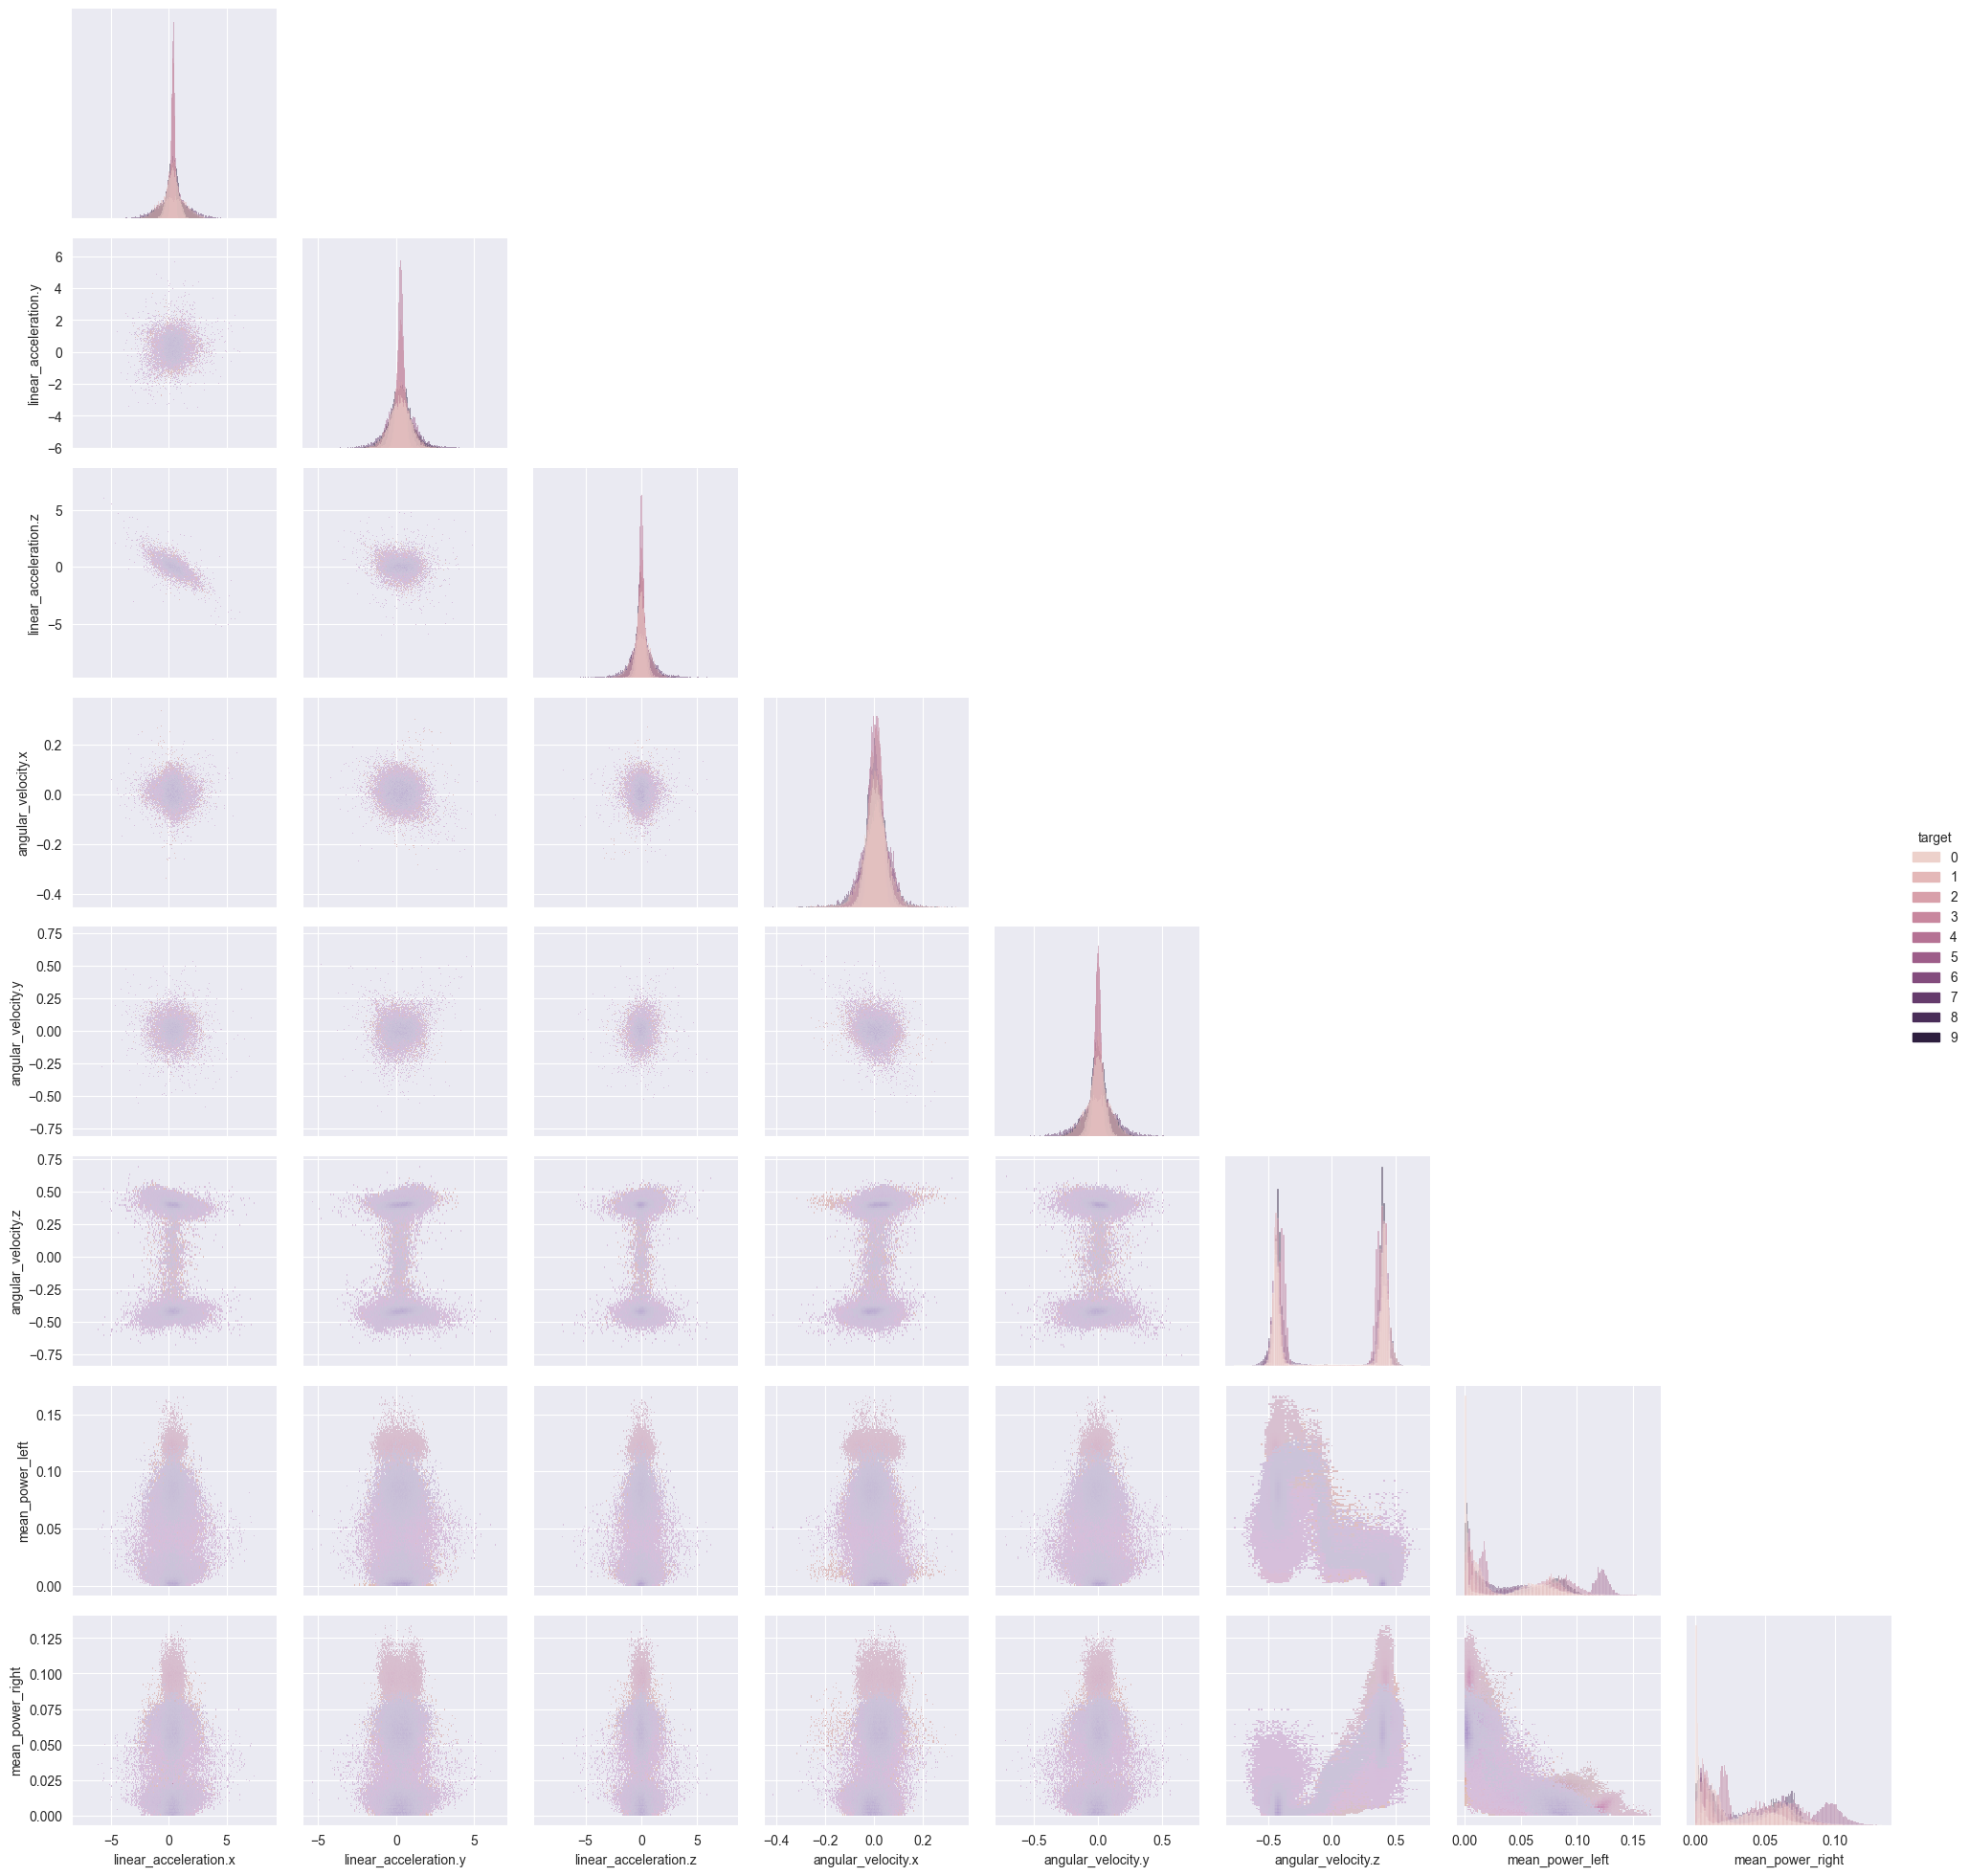

In [22]:
g = sns.PairGrid(X, hue='target', diag_sharey=False, corner=True)
g.map_lower(sns.histplot)
g.map_diag(sns.histplot)
g.add_legend()